# 协同过滤算法

## 基于用户的协同过滤算法(UserCF)
给用户推荐和他兴趣相似的其他用户喜欢的产品
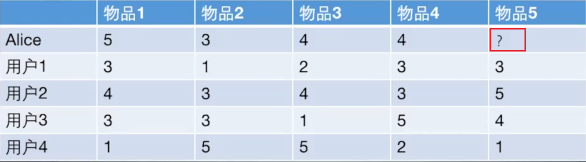应用UserCF算法的两个步骤：
1. 首先根据前面的这些打分情况(或者说已有的用户向量）计算一下Alice和用户1， 2， 3， 4的相似程度， 找出与Alice最相似的n个用户
2. 根据这n个用户对物品5的评分情况和与Alice的相似程度会猜测出Alice对物品5的评分， 如果评分比较高的话， 就把物品5推荐给用户Alice， 否则不推荐。

### 最终结果的预测
可以选出与Alice最相近的前n个用户， 基于他们对物品5的评价猜测出Alice的打分值。
这里常用的方式之一是利用用户相似度和相似用户的评价加权平均获得用户的评价预测， 用下面式子表示：
$$ R_{\mathrm{u}, \mathrm{p}}=\frac{\sum_{\mathrm{s} \in S}\left(w_{\mathrm{u}, \mathrm{s}} \cdot R_{\mathrm{s}, \mathrm{p}}\right)}{\sum_{\mathrm{s} \in S} w_{\mathrm{u}, \mathrm{s}}} $$
这个式子里面， 权重$w_{u,s}$ 是用户$u$和用户$s$的相似度，$R_{s,p}$是用户$s$对物品$p$的评分。
还有一种方式如下， 这种方式考虑的更加前面， 依然是用户相似度作为权值， 但后面不单纯的是其他用户对物品的评分， 而是该物品的评分与此用户的所有评分的差值进行加权平均， 这时候考虑到了有的用户内心的评分标准不一的情况， 即有的用户喜欢打高分， 有的用户喜欢打低分的情况。
$$ P_{i, j}=\bar{R}{i}+\frac{\sum{k=1}^{n}\left(S_{i, k}\left(R_{k, j}-\bar{R}{k}\right)\right)}{\sum{k=1}^{n} S_{j, k}} $$
所以这一种计算方式更为推荐。

In [1]:
import pandas as pd
import numpy as np
import warnings
import random, math, os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
# 定义数据集， 也就是那个表格， 注意这里我们采用字典存放数据， 因为实际情况中数据是非常稀疏的，很少有情况是现在这样
def loadData():
    items={'A': {1: 5, 2: 3, 3: 4, 4: 3, 5: 1},
           'B': {1: 3, 2: 1, 3: 3, 4: 3, 5: 5},
           'C': {1: 4, 2: 2, 3: 4, 4: 1, 5: 5},
           'D': {1: 4, 2: 3, 3: 3, 4: 5, 5: 2},
           'E': {2: 3, 3: 5, 4: 4, 5: 1}
          }
    users={1: {'A': 5, 'B': 3, 'C': 4, 'D': 4},
           2: {'A': 3, 'B': 1, 'C': 2, 'D': 3, 'E': 3},
           3: {'A': 4, 'B': 3, 'C': 4, 'D': 3, 'E': 5},
           4: {'A': 3, 'B': 3, 'C': 1, 'D': 5, 'E': 4},
           5: {'A': 1, 'B': 5, 'C': 5, 'D': 2, 'E': 1}
          }
    return items,users

items, users = loadData()
item_df = pd.DataFrame(items).T
user_df = pd.DataFrame(users).T

In [4]:
"""计算用户相似性矩阵"""
similarity_matrix = pd.DataFrame(np.zeros((len(users), len(users))), index=[1, 2, 3, 4, 5], columns=[1, 2, 3, 4, 5])

# 遍历每条用户-物品评分数据
for userID in users:
    for otheruserId in users:
        vec_user = []
        vec_otheruser = []
        if userID != otheruserId:
            for itemId in items:   # 遍历物品-用户评分数据
                itemRatings = items[itemId]        # 这也是个字典  每条数据为所有用户对当前物品的评分
                if userID in itemRatings and otheruserId in itemRatings:  # 说明两个用户都对该物品评过分
                    vec_user.append(itemRatings[userID])
                    vec_otheruser.append(itemRatings[otheruserId])
            # 这里可以获得相似性矩阵(共现矩阵)
            similarity_matrix[userID][otheruserId] = np.corrcoef(np.array(vec_user), np.array(vec_otheruser))[0][1]
            
similarity_matrix

,1,2,3,4,5
1,0.000000,0.852803,0.707107,0.000000,-0.792118
2,0.852803,0.000000,0.467707,0.489956,-0.900149
3,0.707107,0.467707,0.000000,-0.161165,-0.466569
4,0.000000,0.489956,-0.161165,0.000000,-0.641503
5,-0.792118,-0.900149,-0.466569,-0.641503,0.000000


In [6]:
"""计算前n个相似的用户"""
n = 2
similarity_users = similarity_matrix[1].sort_values(ascending=False)[:n].index.tolist()    # [2, 3]   也就是用户1和用户2
similarity_users

[2, 3]

In [7]:
"""计算最终得分"""
base_score = np.mean(np.array([value for value in users[1].values()]))
weighted_scores = 0.
corr_values_sum = 0.
for user in similarity_users:  # [2, 3]
    corr_value = similarity_matrix[1][user]            # 两个用户之间的相似性
    mean_user_score = np.mean(np.array([value for value in users[user].values()]))    # 每个用户的打分平均值
    weighted_scores += corr_value * (users[user]['E']-mean_user_score)      # 加权分数
    corr_values_sum += corr_value
final_scores = base_score + weighted_scores / corr_values_sum
print('用户Alice对物品5的打分: ', final_scores)
user_df.loc[1]['E'] = final_scores
user_df

用户Alice对物品5的打分:  4.871979899370592


,A,B,C,D,E
1,5.0,3.0,4.0,4.0,4.87198
2,3.0,1.0,2.0,3.0,3.00000
3,4.0,3.0,4.0,3.0,5.00000
4,3.0,3.0,1.0,5.0,4.00000
5,1.0,5.0,5.0,2.0,1.00000


## 缺点

User-based算法存在两个重大问题：
1. 数据稀疏性。一个大型的电子商务推荐系统一般有非常多的物品，用户可能买的其中不到1%的物品，不同用户之间买的物品重叠性较低，导致算法无法找到一个用户的邻居，即偏好相似的用户。这导致UserCF不适用于那些正反馈获取较困难的应用场景(如酒店预订，大件商品购买等低频应用)
2. 算法扩展性。基于用户的协同过滤需要维护用户相似度矩阵以便快速的找出Topn相似用户，该矩阵的存储开销非常大，存储空间随着用户数量的增加而增加，不适合用户数据量大的情况使用。